In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf

In [2]:
manip1 = ExperimentClass.Experiment("20240319_NPQ_lincomycin_long", "SpeedZen")
manip2 = ExperimentClass.Experiment("20240319_NPQ_lincomycin_relaxation", "SpeedZen")
manip2.Data.rename(columns = {"E31" : "E11", "E32": "E12", "E33": "E13", "E34": "E14", "E35": "E15", "E36": "E16", "E37": "E17", "E38": "E18"}, inplace = True)
manip2.Time = manip2.Time + manip1.Time.iloc[-1] + (30*60*1000)

C:\Users\Orlando\AppData\Local\Temp\ipykernel_17644\3693628241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manip2.Data.rename(columns = {"E31" : "E11", "E32": "E12", "E33": "E13", "E34": "E14", "E35": "E15", "E36": "E16", "E37": "E17", "E38": "E18"}, inplace = True)


In [3]:
normalising_vector = []
for col in manip1.Data.columns:
    normalising_vector.append(manip1.Data[col][6])
manip1.Data = manip1.Data.div(normalising_vector, axis=1)
manip2.Data = manip2.Data.div(normalising_vector, axis=1)

manip1.annotations

,E,souche,added_linc_uL,actinic_light,illumination,experiment
0,11,stt7A6,0.00,740,0,0
1,12,stt7A6,0.00,740,0,0
2,13,stt7A6,0.00,740,0,0
3,14,stt7A6,0.00,740,0,0
4,15,stt7A6,0.75,740,0,0
5,16,stt7A6,0.75,740,0,0
6,17,stt7A6,0.75,740,0,0
7,18,stt7A6,0.75,740,0,0


In [4]:
def get_kinetics(time, data):
    time_Fstat = time[3::2]/(1000*60)
    Fstat = data[3::2]
    time_Fmax = time[4::2]/(1000*60)
    Fmax = data[4::2]
    return time_Fstat, Fstat, time_Fmax, Fmax



In [5]:
time_Fstat = []
time_Fmax = []
Fstat = []
Fmax = []
Phi_PSII = []
NPQ = []
for recor in manip1.annotations.E:
    aux_time_Fstat, aux_Fstat, aux_time_Fmax, aux_Fmax = get_kinetics(manip1.Time, manip1.Data[f"E{recor}"])
    time_Fstat.append(aux_time_Fstat)
    Fstat.append(aux_Fstat)
    time_Fmax.append(aux_time_Fmax)
    Fmax.append(aux_Fmax)
    aux_time_Fstat, aux_Fstat, aux_time_Fmax, aux_Fmax = get_kinetics(manip2.Time, manip2.Data[f"E{recor}"])
    time_Fstat[-1] = time_Fstat[-1].append(aux_time_Fstat)
    Fstat[-1] = Fstat[-1].append(aux_Fstat)
    time_Fmax[-1] = time_Fmax[-1].append(aux_time_Fmax)
    Fmax[-1] = Fmax[-1].append(aux_Fmax)
    Phi_PSII.append((Fmax[-1].values-Fstat[-1].values)/Fmax[-1].values)
    NPQ.append((Fmax[-1].values[0]-Fmax[-1].values)/Fmax[-1].values)
    
time_Fstat = np.array(time_Fstat)
time_Fmax = np.array(time_Fmax)
Fstat = np.array(Fstat)
Fmax = np.array(Fmax)
Phi_PSII = np.array(Phi_PSII)
NPQ = np.array(NPQ)

C:\Users\Orlando\AppData\Local\Temp\ipykernel_17644\2699894514.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_Fstat[-1] = time_Fstat[-1].append(aux_time_Fstat)
C:\Users\Orlando\AppData\Local\Temp\ipykernel_17644\2699894514.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Fstat[-1] = Fstat[-1].append(aux_Fstat)
C:\Users\Orlando\AppData\Local\Temp\ipykernel_17644\2699894514.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_Fmax[-1] = time_Fmax[-1].append(aux_time_Fmax)
C:\Users\Orlando\AppData\Local\Temp\ipykernel_17644\2699894514.py:17: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Fmax[-1] = Fmax[-1].append(au

In [6]:
def light_bar(ax, time_vector, light_on, light_off, intensity):
    scale = ax.get_ylim()[1] - ax.get_ylim()[0]
    up = ax.get_ylim()[0]
    down = up - scale*0.06
    time = np.linspace(time_vector[0], time_vector[-1], 1000)
    ax.fill_between(time, down, up, color='black', where=(time < light_on) | (time > light_off))
    ax.fill_between(time, down, up, color='yellow', where=(time >= light_on) & (time <= light_off))
    ax.axvline(light_on, color='k', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axvline(light_off, color='k', linestyle='--', alpha=0.5, linewidth=0.5)
    
    #ax.text((light_off-light_on)/2, up - scale*0.035, f" {intensity} $µE m^{{-2}} s^{{-1}}$", horizontalalignment='center', verticalalignment='center', fontsize=7)

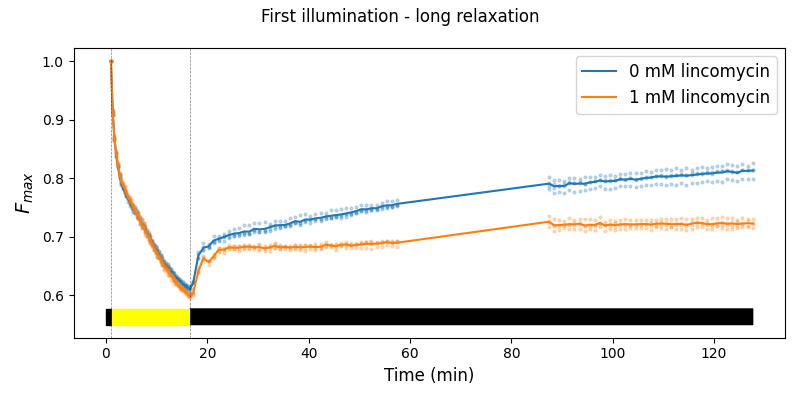

In [7]:
illumination = 0

records_control = list(manip1.annotations[(manip1.annotations["illumination"] == illumination) & (manip1.annotations["added_linc_uL"] == 0)].E)
records_linco = list(manip1.annotations[(manip1.annotations["illumination"] == illumination) & (manip1.annotations["added_linc_uL"] != 0)].E)

marker = 2
line = 1.5
fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle("First illumination - long relaxation")
aux = 0
aux_y = []
for i in records_control:
    index = list(manip1.annotations.E).index(i)
    ax.plot(time_Fmax[index][1:], Fmax[index][1:], 'o', markersize = marker, linewidth = 0.5, color = "C0", alpha=0.25)
    aux_y.append(Fmax[index][1:])
aux_y = np.array(aux_y)
ax.plot(time_Fmax[index][1:], np.mean(aux_y, axis=0), '-', linewidth = line, color = "C0", label= "0 mM lincomycin")
    

aux = 0
aux_y = []
for i in records_linco:
    index = list(manip1.annotations.E).index(i)
    ax.plot(time_Fmax[index][1:], Fmax[index][1:], 'o', markersize = marker, linewidth = 0.5, color = "C1", alpha=0.25)
    aux_y.append(Fmax[index][1:])
aux_y = np.array(aux_y)
ax.plot(time_Fmax[index][1:], np.mean(aux_y, axis=0), '-', linewidth = line, color = "C1", label= "1 mM lincomycin")
    


ax.legend(fontsize=12, loc='upper right')
ax.set_ylabel("$F_{max}$", fontsize=14)
ax.set_xlabel("Time (min)", fontsize=12)

light_bar(ax, time_Fmax[0], 1.1, 16.6, 740)

fig.tight_layout()
fig.savefig(manip1.fig_folder + "/illum_0.png", dpi=300)   


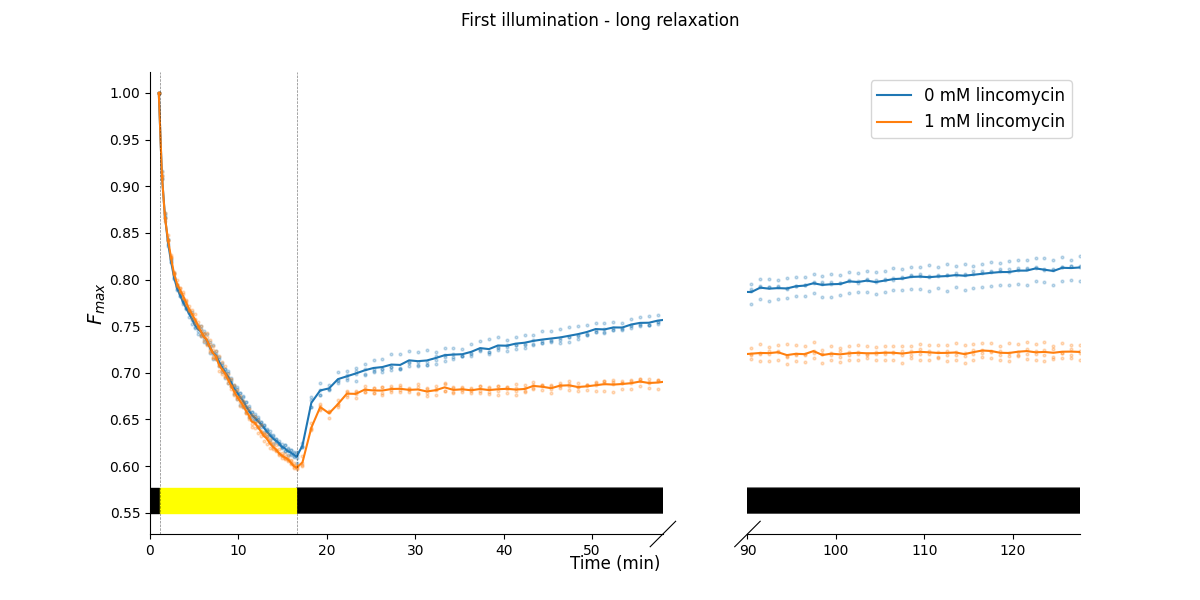

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

illumination = 0

records_control = list(manip1.annotations[(manip1.annotations["illumination"] == illumination) & (manip1.annotations["added_linc_uL"] == 0)].E)
records_linco = list(manip1.annotations[(manip1.annotations["illumination"] == illumination) & (manip1.annotations["added_linc_uL"] != 0)].E)

marker = 2
line = 1.5

# Create broken axes
fig = plt.figure(figsize=(12, 6))
bax = brokenaxes(xlims=((0, 58), (90, max(time_Fmax[0]))), hspace=0)
fig.suptitle("First illumination - long relaxation")

aux_y = []
for i in records_control:
    index = list(manip1.annotations.E).index(i)
    bax.plot(time_Fmax[index][1:], Fmax[index][1:], 'o', markersize=marker, linewidth=0.5, color="C0", alpha=0.25)
    aux_y.append(Fmax[index][1:])
aux_y = np.array(aux_y)
bax.plot(time_Fmax[index][1:], np.mean(aux_y, axis=0), '-', linewidth=line, color="C0", label="0 mM lincomycin")

aux_y = []
for i in records_linco:
    index = list(manip1.annotations.E).index(i)
    bax.plot(time_Fmax[index][1:], Fmax[index][1:], 'o', markersize=marker, linewidth=0.5, color="C1", alpha=0.25)
    aux_y.append(Fmax[index][1:])
aux_y = np.array(aux_y)
bax.plot(time_Fmax[index][1:], np.mean(aux_y, axis=0), '-', linewidth=line, color="C1", label="1 mM lincomycin")

bax.legend(fontsize=12, loc='upper right')
bax.set_ylabel("$F_{max}$", fontsize=14)
bax.set_xlabel("Time (min)", fontsize=12)

# Adjust the light_bar function to work with brokenaxes if needed

light_bar(bax.axs[0], time_Fmax[0], 1.1, 16.6, 740)
light_bar(bax.axs[1], time_Fmax[0], 1.1, 16.6, "")


fig.savefig(manip1.fig_folder + "/illum_break.png", dpi=300)

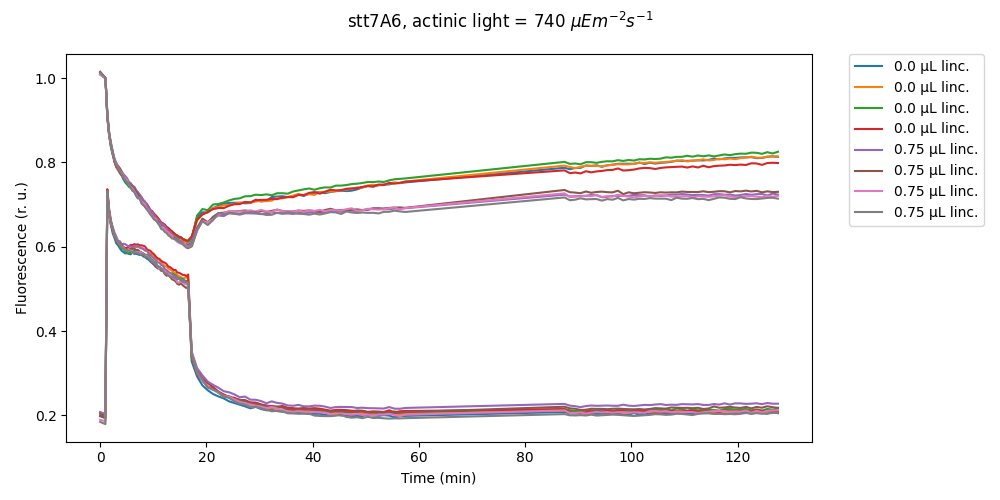

In [9]:
#souches = ["stt7A6", "stt7A20", "WT4A", "t222"]
souches = ["stt7A6"]
experiment = 0
illumination = 0

for i, k in enumerate(souches):
    records = list(manip2.annotations[(manip2.annotations.souche == souches[i]) & (manip2.annotations.experiment == experiment) & (manip2.annotations.illumination == illumination)].E.astype(int))
    fig, ax = plt.subplots(figsize = (10, 5))
    light = manip2.annotations[(manip2.annotations.souche == souches[i]) & (manip2.annotations.experiment == experiment)].actinic_light.values[0]
    fig.suptitle(f"{k}, actinic light = {light}" + " $µEm^{-2}s^{-1}$")
    for j, record in enumerate(records):
        index = manip2.annotations[manip2.annotations.E == record].index[0]
        ax.plot(time_Fstat[index], Fstat[index], '-', markersize = 2, label = f'{manip2.annotations[manip2.annotations.E == record].added_linc_uL.values[0]} µL linc.', color = f'C{j}')
        ax.plot(time_Fmax[index], Fmax[index], '-', markersize = 2, color = f'C{j}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Fluorescence (r. u.)")
    fig.tight_layout()
    fig.savefig(manip2.fig_folder + f"/{k}_{light}µE_{illumination}.png", dpi = 300)
    

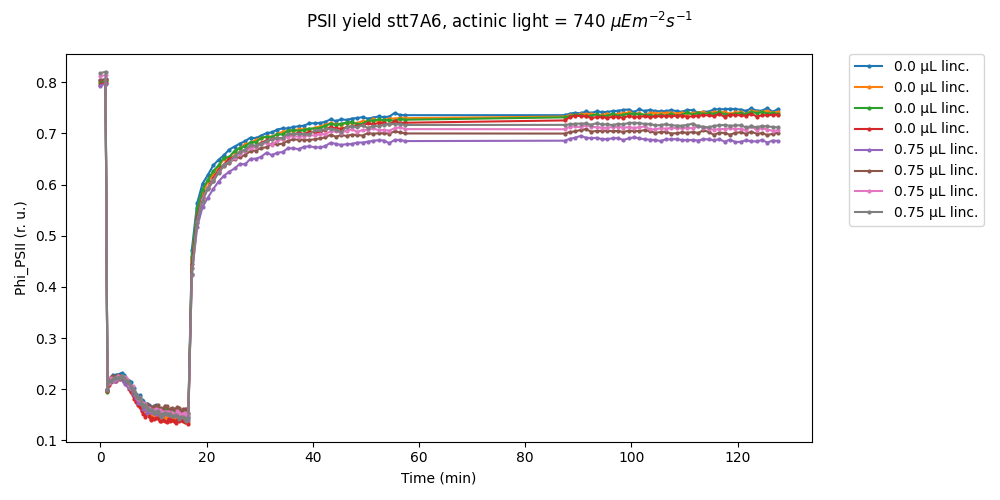

In [10]:
souches = ["stt7A6"]
experiment = 0
illumination = 0

for i, k in enumerate(souches):
    records = list(manip2.annotations[(manip2.annotations.souche == souches[i]) & (manip2.annotations.experiment == experiment) & (manip2.annotations.illumination == illumination)].E.astype(int))
    fig, ax = plt.subplots(figsize = (10, 5))
    light = manip2.annotations[(manip2.annotations.souche == souches[i]) & (manip2.annotations.experiment == experiment)].actinic_light.values[0]
    fig.suptitle(f"PSII yield {k}, actinic light = {light}" + " $µEm^{-2}s^{-1}$")
    for j, record in enumerate(records):
        index = manip2.annotations[manip2.annotations.E == record].index[0]
        ax.plot(time_Fstat[index], Phi_PSII[index], 'o-', markersize = 2, label = f'{manip2.annotations[manip2.annotations.E == record].added_linc_uL.values[0]} µL linc.', color = f'C{j}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Phi_PSII (r. u.)")
    fig.tight_layout()
    fig.savefig(manip2.fig_folder + f"/phi_PSII_{k}_{light}µE_{illumination}.png", dpi = 300)

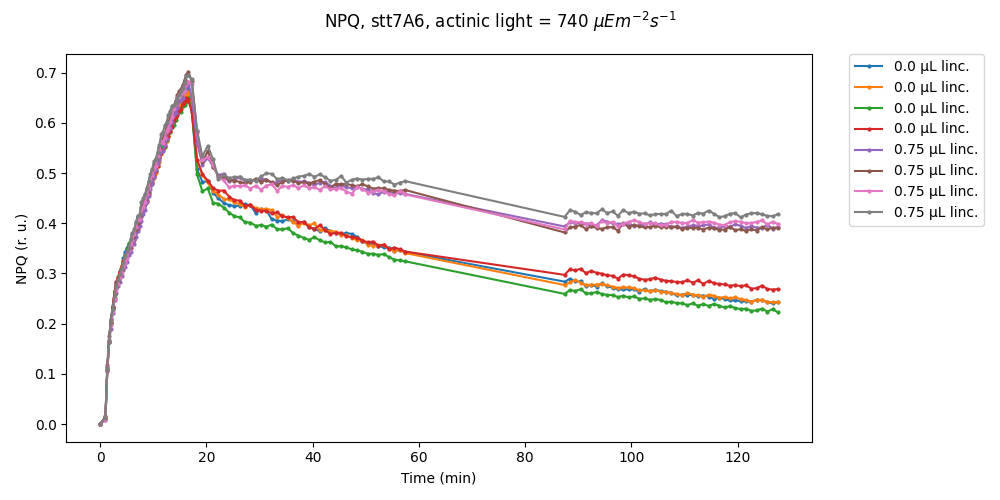

In [11]:
souches = ["stt7A6"]
experiment = 0
illumination = 0

for i, k in enumerate(souches):
    records = list(manip2.annotations[(manip2.annotations.souche == souches[i]) & (manip2.annotations.experiment == experiment) & (manip2.annotations.illumination == illumination)].E.astype(int))
    fig, ax = plt.subplots(figsize = (10, 5))
    light = manip2.annotations[(manip2.annotations.souche == souches[i]) & (manip2.annotations.experiment == experiment)].actinic_light.values[0]
    fig.suptitle(f"NPQ, {k}, actinic light = {light}" + " $µEm^{-2}s^{-1}$")
    for j, record in enumerate(records):
        index = manip2.annotations[manip2.annotations.E == record].index[0]
        ax.plot(time_Fstat[index], NPQ[index], 'o-', markersize = 2, label = f'{manip2.annotations[manip2.annotations.E == record].added_linc_uL.values[0]} µL linc.', color = f'C{j}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("NPQ (r. u.)")
    fig.tight_layout()
    fig.savefig(manip2.fig_folder + f"/NPQ_{k}_{light}µE_{illumination}.png", dpi = 300)

In [12]:
manip1 = ExperimentClass.Experiment("20240319_NPQ_lincomycin_long", "SpeedZen")

In [13]:
normalising_vector = []
for col in manip1.Data.columns:
    normalising_vector.append(manip1.Data[col][6])
manip1.Data = manip1.Data.div(normalising_vector, axis=1)

manip1.annotations

,E,souche,added_linc_uL,actinic_light,illumination,experiment
0,11,stt7A6,0.00,740,0,0
1,12,stt7A6,0.00,740,0,0
2,13,stt7A6,0.00,740,0,0
3,14,stt7A6,0.00,740,0,0
4,15,stt7A6,0.75,740,0,0
5,16,stt7A6,0.75,740,0,0
6,17,stt7A6,0.75,740,0,0
7,18,stt7A6,0.75,740,0,0


In [14]:
def get_kinetics(time, data):
    time_Fstat = time[3::2]/(1000*60)
    Fstat = data[3::2]
    time_Fmax = time[4::2]/(1000*60)
    Fmax = data[4::2]
    return time_Fstat, Fstat, time_Fmax, Fmax



In [15]:
time_Fstat = []
time_Fmax = []
Fstat = []
Fmax = []
Phi_PSII = []
NPQ = []
for recor in manip1.annotations.E:
    aux_time_Fstat, aux_Fstat, aux_time_Fmax, aux_Fmax = get_kinetics(manip1.Time, manip1.Data[f"E{recor}"])
    time_Fstat.append(aux_time_Fstat)
    Fstat.append(aux_Fstat)
    time_Fmax.append(aux_time_Fmax)
    Fmax.append(aux_Fmax)
    Phi_PSII.append((Fmax[-1].values-Fstat[-1].values)/Fmax[-1].values)
    NPQ.append((Fmax[-1].values[0]-Fmax[-1].values)/Fmax[-1].values)
    
time_Fstat = np.array(time_Fstat)
time_Fmax = np.array(time_Fmax)
Fstat = np.array(Fstat)
Fmax = np.array(Fmax)
Phi_PSII = np.array(Phi_PSII)
NPQ = np.array(NPQ)

In [24]:
def light_bar(ax, time_vector, light_on, light_off, intensity):
    scale = ax.get_ylim()[1] - ax.get_ylim()[0]
    up = ax.get_ylim()[0] + scale*0.1
    down = up - scale*0.06
    time = np.linspace(time_vector[0], time_vector[-1], 1000)
    ax.fill_between(time, down, up, color='black', where=(time < light_on) | (time > light_off))
    ax.fill_between(time, down, up, color='yellow', where=(time >= light_on) & (time <= light_off))
    ax.axvline(light_on, color='k', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axvline(light_off, color='k', linestyle='--', alpha=0.5, linewidth=0.5)
    
    #ax.text((light_off-light_on)/2, up - scale*0.035, f"{intensity} $µmol(photons) m^{{-2}} s^{{-1}}$", horizontalalignment='center', verticalalignment='center', fontsize=9)

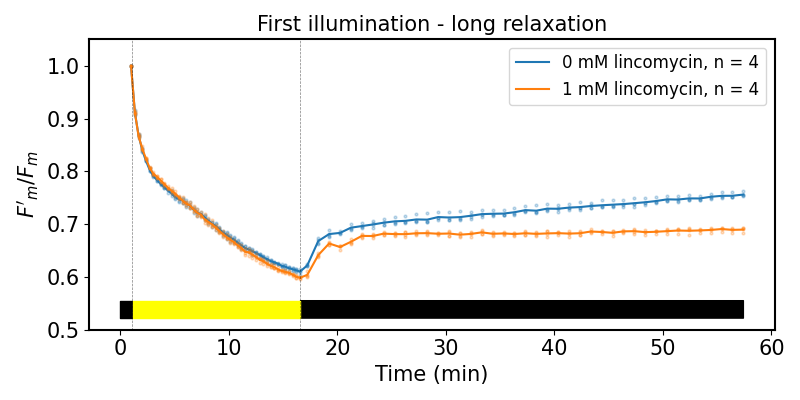

In [25]:
illumination = 0

records_control = list(manip1.annotations[(manip1.annotations["illumination"] == illumination) & (manip1.annotations["added_linc_uL"] == 0)].E)
records_linco = list(manip1.annotations[(manip1.annotations["illumination"] == illumination) & (manip1.annotations["added_linc_uL"] != 0)].E)

marker = 2
line = 1.5
fig, ax = plt.subplots(figsize=(8, 4))
aux = 0
aux_y = []
for i in records_control:
    index = list(manip1.annotations.E).index(i)
    ax.plot(time_Fmax[index][1:], Fmax[index][1:], 'o', markersize = marker, linewidth = 0.5, color = "C0", alpha=0.25)
    aux_y.append(Fmax[index][1:])
aux_y = np.array(aux_y)
ax.plot(time_Fmax[index][1:], np.mean(aux_y, axis=0), '-', linewidth = line, color = "C0", label= f"0 mM lincomycin, n = {len(records_control)}")
    

aux = 0
aux_y = []
for i in records_linco:
    index = list(manip1.annotations.E).index(i)
    ax.plot(time_Fmax[index][1:], Fmax[index][1:], 'o', markersize = marker, linewidth = 0.5, color = "C1", alpha=0.25)
    aux_y.append(Fmax[index][1:])
aux_y = np.array(aux_y)
ax.plot(time_Fmax[index][1:], np.mean(aux_y, axis=0), '-', linewidth = line, color = "C1", label= f"1 mM lincomycin, n = {len(records_linco)}")
    


ax.legend(fontsize=12, loc='upper right')
ax.set_ylabel("$F_{max}$", fontsize=14)
ax.set_xlabel("Time (min)", fontsize=12)

ax = tools.poster_axes(ax, title = "First illumination - long relaxation", xlabel = "Time (min)", ylabel = "$F'_m/F_m$", legendfontsize=12)

ax.set_ylim(0.5, 1.05)

light_bar(ax, time_Fmax[0], 1.1, 16.6, 740)

fig.tight_layout()
fig.savefig(manip1.fig_folder + "/illum_no_break.png", dpi=300)   


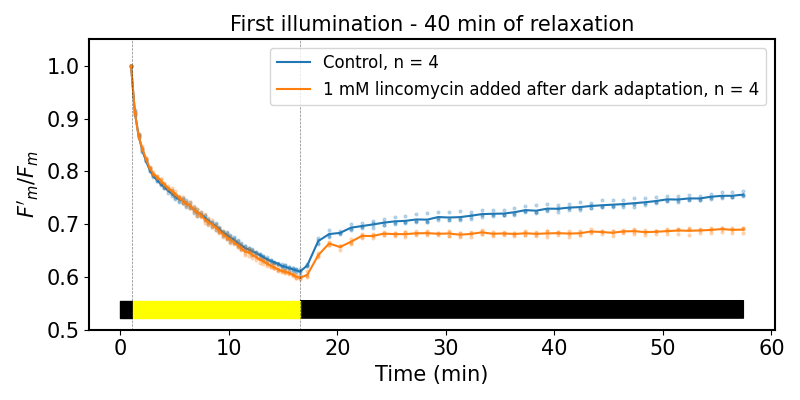

In [33]:
illumination = 0

records_control = list(manip1.annotations[(manip1.annotations["illumination"] == illumination) & (manip1.annotations["added_linc_uL"] == 0)].E)
records_linco = list(manip1.annotations[(manip1.annotations["illumination"] == illumination) & (manip1.annotations["added_linc_uL"] != 0)].E)

marker = 2
line = 1.5
fig, ax = plt.subplots(figsize=(8, 4))
aux = 0
aux_y = []
end_ctrl = []
end_linco = []
for i in records_control:
    index = list(manip1.annotations.E).index(i)
    ax.plot(time_Fmax[index][1:], Fmax[index][1:], 'o', markersize = marker, linewidth = 0.5, color = "C0", alpha=0.25)
    aux_y.append(Fmax[index][1:])
    end_ctrl.append(Fmax[index][-1])
aux_y = np.array(aux_y)
ax.plot(time_Fmax[index][1:], np.mean(aux_y, axis=0), '-', linewidth = line, color = "C0", label= f"Control, n = {len(records_control)}")

    

aux = 0
aux_y = []
for i in records_linco:
    index = list(manip1.annotations.E).index(i)
    ax.plot(time_Fmax[index][1:], Fmax[index][1:], 'o', markersize = marker, linewidth = 0.5, color = "C1", alpha=0.25)
    aux_y.append(Fmax[index][1:])
    end_linco.append(Fmax[index][-1])
    
aux_y = np.array(aux_y)
ax.plot(time_Fmax[index][1:], np.mean(aux_y, axis=0), '-', linewidth = line, color = "C1", label= f"1 mM lincomycin added after dark adaptation, n = {len(records_linco)}")
    


ax.legend(fontsize=12, loc='upper right')
ax.set_ylabel("$F_{max}$", fontsize=14)
ax.set_xlabel("Time (min)", fontsize=12)

ax = tools.poster_axes(ax, title = "First illumination - 40 min of relaxation", xlabel = "Time (min)", ylabel = "$F'_m/F_m$", legendfontsize=12)

ax.set_ylim(0.5, 1.05)

light_bar(ax, time_Fmax[0], 1.1, 16.6, 740)

fig.tight_layout()
fig.savefig(manip1.fig_folder + "/illum_no_break.png", dpi=300)   


In [32]:
print(f"Control: {np.mean(end_ctrl):.3f} ± {np.std(end_ctrl):.3f}")
print(f"Linco: {np.mean(end_linco):.3f} ± {np.std(end_linco):.3f}")

Control: 0.756 ± 0.004
Linco: 0.690 ± 0.004


In [30]:
import numpy as np
from scipy.stats import ttest_ind

# Perform the t-test
t_stat, p_value = ttest_ind(end_ctrl, end_linco)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("The difference between end_ctrl and end_linco is statistically significant.")
else:
    print("The difference between end_ctrl and end_linco is not statistically significant.")

T-statistic: 21.154087531008358
P-value: 7.273637359210313e-07
The difference between end_ctrl and end_linco is statistically significant.
